In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pandas as pd
import arviz as az
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import theano
import theano.tensor as tt 
print(theano.config.device)

np.random.seed(42)
pm.set_tt_rng(42)


cpu


In [2]:
def encode_counts(counts):
    # turn counts of position into word-style encoding
    # https://laptrinhx.com/topic-modeling-with-pymc3-398251916/
    # A[C>A]A, A[C>G]A, A[C>T]A, A[C>A]C... T[T>G]T
    
    x32 = np.tile([np.arange(16), np.arange(16, 32)], 3).reshape(-1)
    y6 = np.repeat([0,1,2,0,2,1], 16)
    
    S, C = counts.shape
    sel = [np.repeat(range(C), counts[i].astype(int)) for i in range(S)]

    X = [x32[s] for s in sel]
    Y = [y6[s] for s in sel]
    
    return X, Y

In [3]:
C = 32
M = 3
J = 6
K = 5
N = np.array([5, 100, 100, 1000])
S = len(N)

# Hyper-parameter for priors
alpha = np.ones(C) * 0.1
psi = np.ones(J)
gamma = np.ones(K) * 0.1
gamma = np.array([5,1,1,1,1]) * 0.1
beta = np.ones((K,4)) * 0.1
beta = np.repeat(np.array([[1, 0.1, 1, 1]]), K, axis=0)

In [4]:
# Generate data
phi_gen = pm.Dirichlet.dist(a=alpha, shape=(C)).random(size = J)
theta_gen = pm.Dirichlet.dist(a=psi).random(size = S)
A_gen = pm.Dirichlet.dist(a=gamma, shape=(J, K)).random(size = S)
# ACGT
# 0123
eta_gen = np.vstack([pm.Dirichlet.dist(a=beta[:,[0,2,3]]).random(size=C//2), 
                     pm.Dirichlet.dist(a=beta[:,[0,1,2]]).random(size=C//2)])

In [5]:
W=(theta_gen@phi_gen).T
Q=np.einsum('sj,sjk->sk', theta_gen, A_gen)@eta_gen
B=np.einsum('cs,csm->scm',W,Q).reshape(S, -1)
data = np.vstack([d.random(size = 1) for d in map(pm.Multinomial.dist, N, B)])
X_encoded, Y_encoded = encode_counts(data)

## Full two step model

In [6]:
with pm.Model() as full_model:

    phi = pm.Dirichlet('phi', a=alpha, shape=(J, C))
    theta = pm.Dirichlet("theta", a=psi, shape=(S, J))
    A = pm.Dirichlet("A", a=gamma, shape = (S, J, K))
    etaC = pm.Dirichlet("etaC", a=beta[:,[0,2,3]], shape=(C//2, K, M))
    etaT = pm.Dirichlet("etaT", a=beta[:,[0,1,2]], shape=(C//2, K, M))
    eta = pm.Deterministic('eta', pm.math.concatenate([etaC, etaT], axis=0))

    
    for s in range(S):
        # draw damage context signature
        z = pm.Categorical(f"z_{s}", p=theta[s], shape=N[s])
        # draw mutation damage context
        x = pm.Categorical(f"x_{s}", p=phi[z], shape=N[s], observed=X_encoded[s])
        # draw mutation signature
        v = pm.Categorical(f"v_{s}", p=A[s,z], shape=N[s])
        # draw mutation
        y = pm.Categorical(f"y_{s}", p=eta[x,v], shape=N[s], observed=Y_encoded[s])

Fit the model

In [7]:
with full_model:    
    full_trace = pm.sample(1000, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [etaT, etaC, A, theta, phi]
>CategoricalGibbsMetropolis: [v_3, z_3, v_2, z_2, v_1, z_1, v_0, z_0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7699 seconds.
/home/harrigan/miniconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 448 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 532 divergences after tuning. Increase `target_accept` or reparameterize.
There were 261 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 419 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The est

Sanity check the result

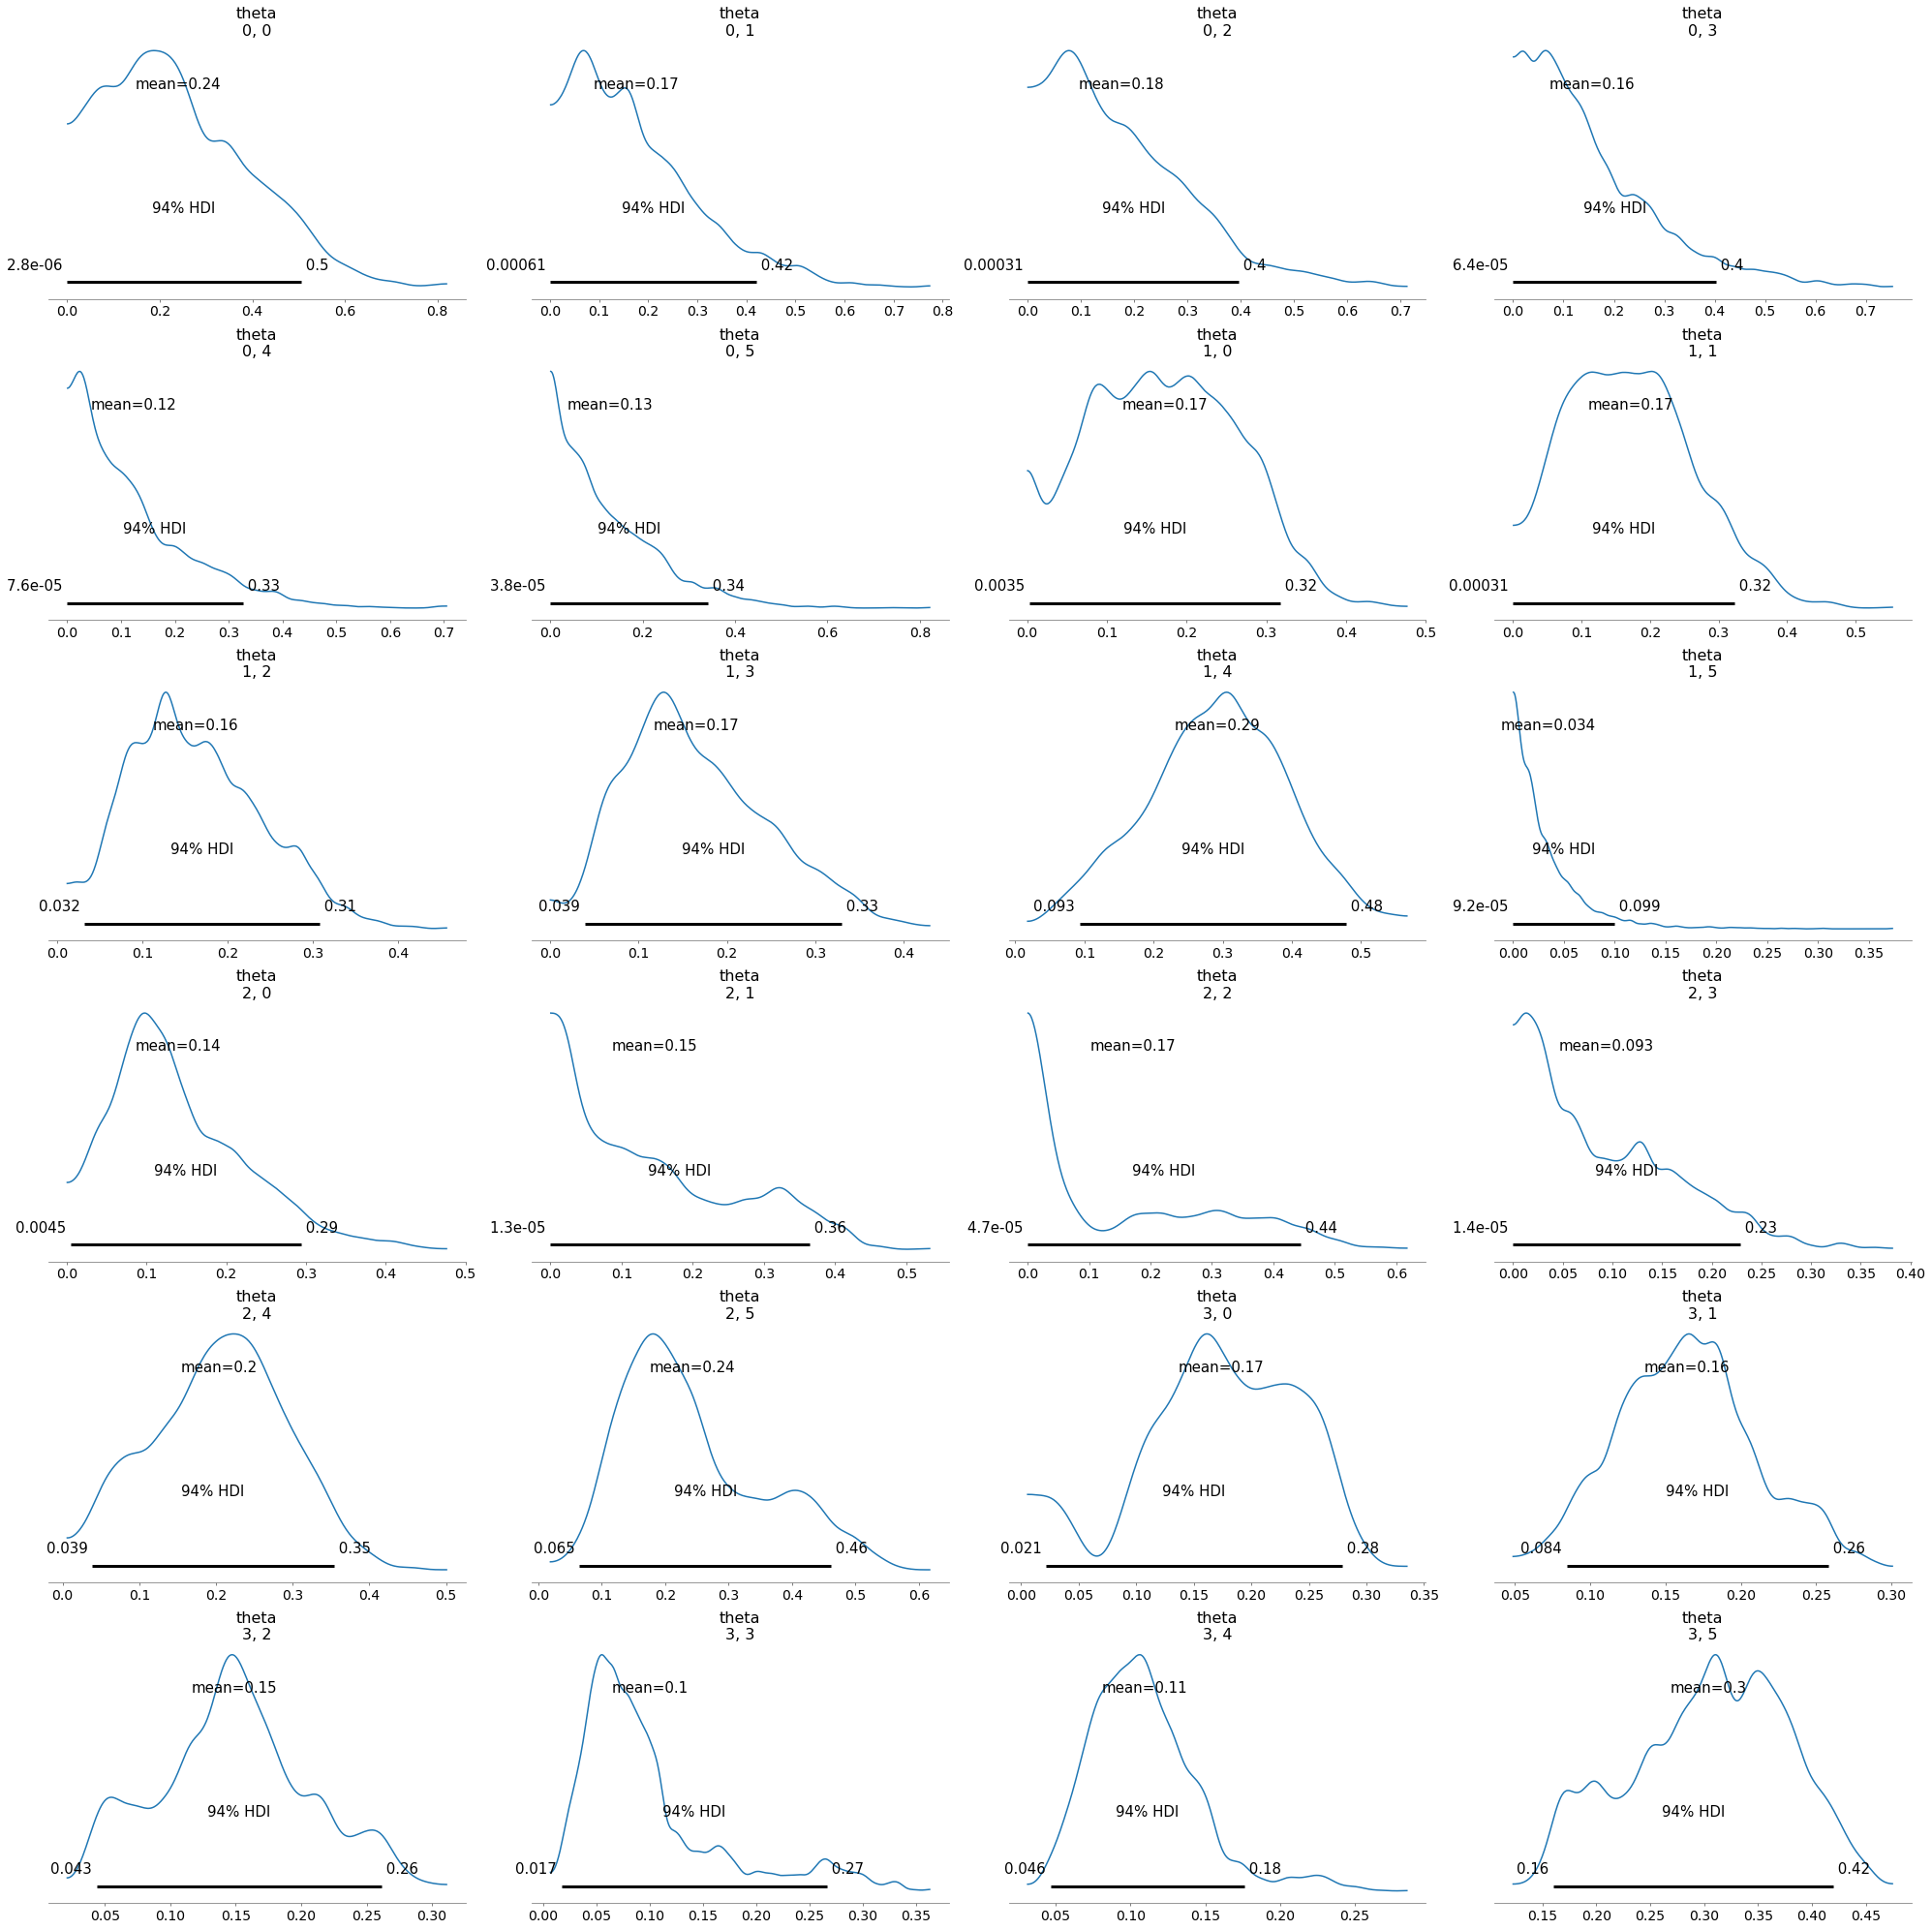

In [11]:
az.plot_posterior(full_trace, var_names=['theta']);

ValueError: num must be 1 <= num <= 2, not 3

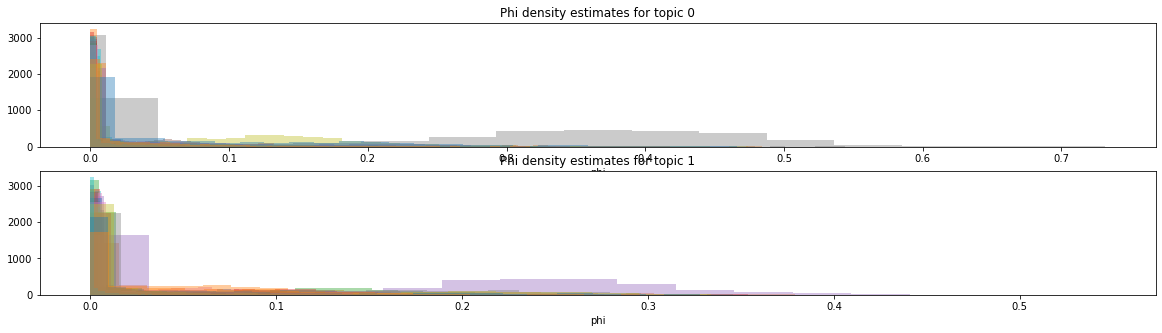

In [13]:
plt.figure(figsize=(20,5))
for j in range(J):
    plt.subplot(J,1,j+1)
    for c in range(C):
        sns.distplot(full_trace.posterior['phi'][:, :, j, c], kde=False, hist=True)
    plt.title(f'Phi density estimates for topic {j}')


In [14]:
with full_model:
    phi_map = pm.find_MAP()['phi']
    print(np.diag(cosine_similarity(phi_map, phi_gen)))



[0.33513603 0.48945787 0.42996272 0.42211385 0.44249552 0.01645377]


In [ ]:
with full_model:
    ppc = pm.sample_posterior_predictive(
        full_trace, random_seed=5
    )
    az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=full_model));

## 'collapsed' two step LDA

In [15]:
with pm.Model() as collapsed_model:

    phi = pm.Dirichlet('phi', a=alpha, shape=(J, C))
    theta = pm.Dirichlet("theta", a=psi, shape=(S, J))
    A = pm.Dirichlet("A", a=gamma, shape = (S, J, K))
    etaC = pm.Dirichlet("etaC", a=beta[:,[0,2,3]], shape=(C//2, K, M))
    etaT = pm.Dirichlet("etaT", a=beta[:,[0,1,2]], shape=(C//2, K, M))
    eta = pm.Deterministic('eta', pm.math.concatenate([etaC, etaT], axis=0))
    
    for s in range(S):
        W = pm.math.matrix_dot(theta[s], phi)
        Q = pm.math.matrix_dot(theta[s],A[s],eta)
                               
        # mutation counts
        w = pm.Multinomial(f'sample_{s}', n = N[s], p = tt.batched_dot(W,Q).reshape((-1,)) , observed=data[s])
    


etaC __str__ = [16  5  3]
etaT __str__ = [16  5  3]


In [16]:
print((theta_gen[0]@phi_gen))
print((theta_gen[0]@A_gen[0]@eta_gen).shape)
np.tensordot(theta_gen, A_gen, 0).shape
#np.outer((theta_gen[0]@phi_gen), (theta_gen[0]@A_gen[0]@eta_gen)[0]).shape
theta_gen.shape

[0.0020207  0.00354249 0.03231492 0.00334743 0.02557259 0.05045725
 0.0160791  0.00145905 0.01002187 0.00174126 0.00117651 0.00253571
 0.01215833 0.05226891 0.0162603  0.07571966 0.00063395 0.08213149
 0.07035402 0.11003755 0.02500124 0.04481707 0.00057378 0.04150255
 0.05402548 0.10403656 0.06592157 0.00970602 0.03946681 0.00665095
 0.01157112 0.02689375]
(32, 3)


(4, 6)

Fit the model

In [17]:
with collapsed_model:
    collapsed_trace = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [etaT, etaC, A, theta, phi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 661 seconds.
There were 936 divergences after tuning. Increase `target_accept` or reparameterize.
There were 826 divergences after tuning. Increase `target_accept` or reparameterize.
There were 987 divergences after tuning. Increase `target_accept` or reparameterize.
There were 935 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [ ]:
#pm.plot_trace(collapsed_trace);
#az.plot_forest(collapsed_trace, r_hat=True);
az.plot_posterior(collapsed_trace, var_names=['theta']);

/home/harrigan/miniconda3/envs/pymc3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


ValueError: num must be 1 <= num <= 2, not 3

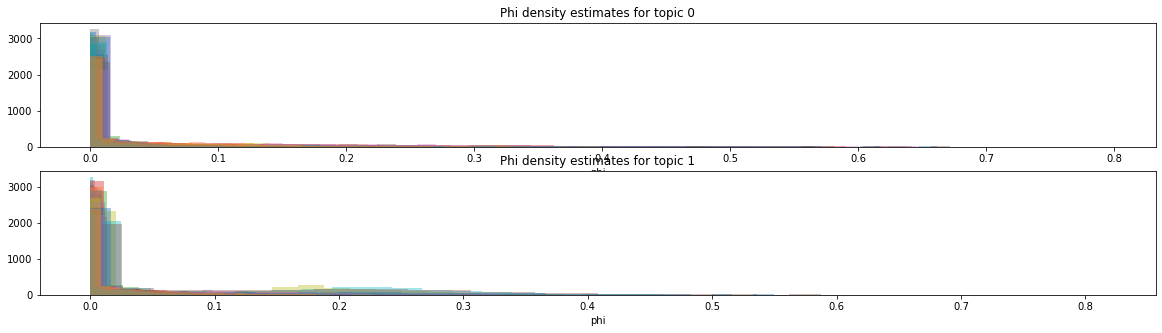

In [19]:
plt.figure(figsize=(20,5))
for j in range(J):
    plt.subplot(2,1,j+1)
    for c in range(C):
        sns.distplot(collapsed_trace.posterior['phi'][:, :, j, c], kde=False, hist=True)
    plt.title(f'Phi density estimates for topic {j}')

In [20]:
with collapsed_model:
    phi_map = pm.find_MAP()['phi']
    print(np.diag(cosine_similarity(phi_map, phi_gen)))


[0.05871006 0.48777891 0.23071426 0.15805016 0.19176553 0.11369637]


In [28]:
with collapsed_model:
    ppc = pm.sample_posterior_predictive(
        collapsed_trace, random_seed=5
    )
    az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=collapsed_model));

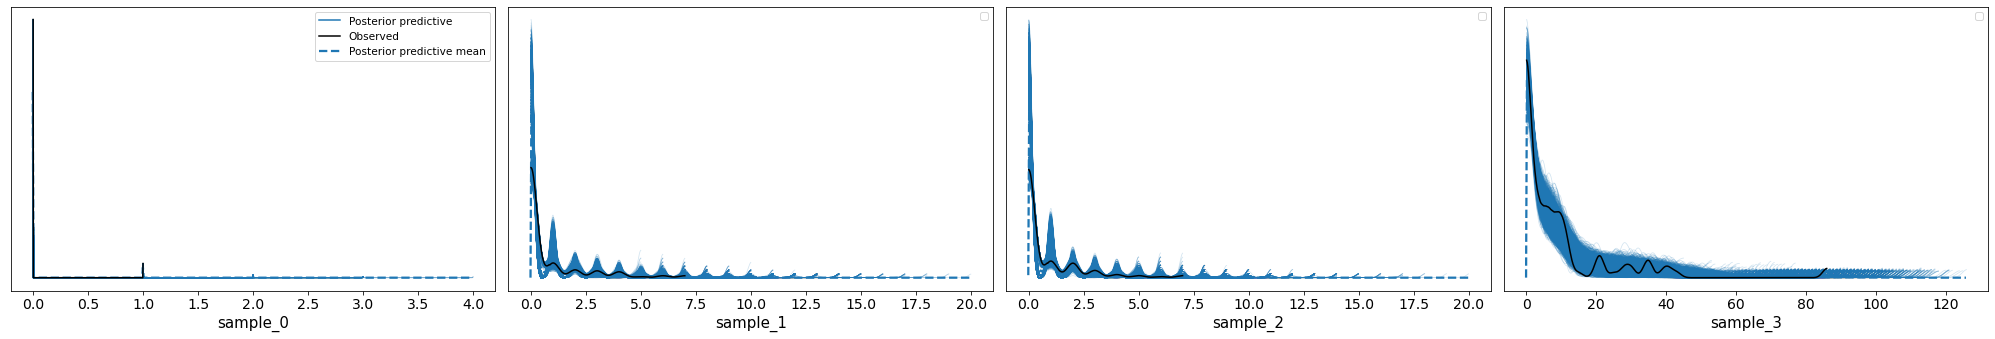